In [1]:
using Revise

In [5]:
using QuantumStates, UnitsToValue, DataFrames, PrettyTables

### Load Hamiltonian

In [55]:
H = load_from_file("CaOH_X010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")

H = subspace(H, (N=(1,2),))

# Add AC Stark effect from trap
au = 1.64877727436e-41

# ODT
w = 24e-6; P = @with_unit 12.6 "W"; I_trap = 2P / (π * w^2);
α_par = 142.6
α_perp = 234.6

# # Tweezer
# w = 2.0e-6; P = @with_unit 130 "mW"; I_trap = 2P / (π * w^2);
# α_par = 186.5
# α_perp = 393.2

const α = [(1/3)*(α_par + 2α_perp), 0, (2/3)*(α_par - α_perp)] .* au
const θ = π/2
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
scalar_polarizability(state, state′) = polarizability(state, state′, α .* [1,0,0], ϵ_trap)
tensor_polarizability(state, state′) = polarizability(state, state′, α .* [0,0,1], ϵ_trap)
H = add_to_H(H, :I_scalar, (1 / h) * scalar_polarizability)
H = add_to_H(H, :I_tensor, (1 / h) * tensor_polarizability)

# Add DC Stark effect
const μX = 1.465 * (1e-21 / c) / h
H = add_to_H(H, :E, (1e2 * μX) * Stark) # 1e2 converts from V/m to V/cm

# Add Zeeman effect
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
H = add_to_H(H, :B_z, gS * (1e-4 * μB / h) * Zeeman_z)
;

In [149]:
H.parameters.E = 25.
H.parameters.B_z = 0.
H.parameters.I_scalar = (0.5/3.5) * I_trap / (2ε0 * c)
H.parameters.I_tensor = (0.5/3.5) * I_trap / (2ε0 * c)

# H.parameters.bFX = 2.2e6
# H.parameters.cX = 2.6e6

full_evaluate!(H)
solve!(H)
_, N1_J12_states = subspace(H.states, (N=1, J=1/2), 0.5)
_, N1_J32_states = subspace(H.states, (N=1, J=3/2), 0.5)
_, N2_J32_states = subspace(H.states, (N=2, J=3/2), 0.5) 
_, N2_states = subspace(H.states, (N=2,))
;

Row,State,N,F,J,M,State_1,N_1,F_1,J_1,M_1,f,tdm
,Integer,Rational…,Rational…,Rational…,Rational…,Integer,Rational…,Rational…,Rational…,Rational…,Float64,Float64
1,3,1//1,1//1,1//2,0//1,46,2//1,2//1,3//2,1//1,347.567,-0.00340941
2,3,1//1,1//1,1//2,0//1,46,2//1,2//1,3//2,1//1,347.567,0.00340941
3,3,1//1,1//1,1//2,0//1,47,2//1,2//1,3//2,-1//1,347.64,-0.00563658
4,3,1//1,1//1,1//2,0//1,47,2//1,2//1,3//2,-1//1,347.64,-0.00563658
5,2,1//1,1//1,1//2,1//1,45,2//1,2//1,3//2,0//1,347.682,-0.0121754
6,2,1//1,1//1,1//2,1//1,45,2//1,2//1,3//2,0//1,347.682,0.0121754
7,1,1//1,1//1,1//2,-1//1,45,2//1,2//1,3//2,0//1,347.693,-0.0231206
8,1,1//1,1//1,1//2,-1//1,45,2//1,2//1,3//2,0//1,347.693,-0.0231206
9,1,1//1,1//1,1//2,-1//1,46,2//1,2//1,3//2,1//1,347.716,-0.0445332


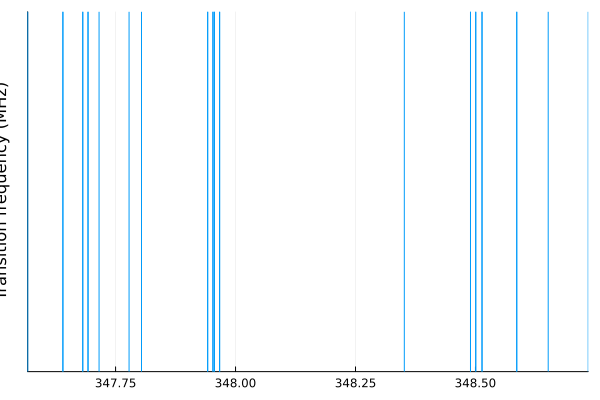

In [154]:
# |N=1, J=1/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
transitions = compute_transitions(N1_J12_states, N2_J32_states, -1, threshold=1e-7)
transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, 0, threshold=1e-7)]
transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-7)]
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :J, :M, :State_1, :N_1, :F_1, :J_1, :M_1, :f, :tdm])
df.f .= df.f .- 39700e6
df.f .*= 1e-6
filter!(row -> row.J == 1/2, df)
filter!(row -> row.F == 1, df)
filter!(row -> row.J_1 == 3/2, df)
filter!(row -> row.f > 0, df)
filter!(row -> 340 < row.f < 350, df)

# pretty_table(df; nosubheader=true)

display(df)
using Plots
vline(df.f, legend=nothing)
plot!(
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

Row,State,N,F,J,M,State_1,N_1,F_1,J_1,M_1,f,tdm
,Integer,Rational…,Rational…,Rational…,Rational…,Integer,Rational…,Rational…,Rational…,Rational…,Float64,Float64
1,12,1//1,2//1,3//2,0//1,45,2//1,2//1,3//2,0//1,319.973,-0.0763794
2,12,1//1,2//1,3//2,0//1,46,2//1,2//1,3//2,1//1,319.996,-0.0423429
3,12,1//1,2//1,3//2,0//1,46,2//1,2//1,3//2,1//1,319.996,-0.0423429
4,12,1//1,2//1,3//2,0//1,47,2//1,2//1,3//2,-1//1,320.069,-0.0409637
5,12,1//1,2//1,3//2,0//1,47,2//1,2//1,3//2,-1//1,320.069,0.0409637
6,11,1//1,2//1,3//2,-1//1,45,2//1,2//1,3//2,0//1,320.078,0.0243158
7,11,1//1,2//1,3//2,-1//1,45,2//1,2//1,3//2,0//1,320.078,0.0243158
8,11,1//1,2//1,3//2,-1//1,46,2//1,2//1,3//2,1//1,320.101,0.0604843
9,10,1//1,2//1,3//2,1//1,45,2//1,2//1,3//2,0//1,320.128,0.00609447


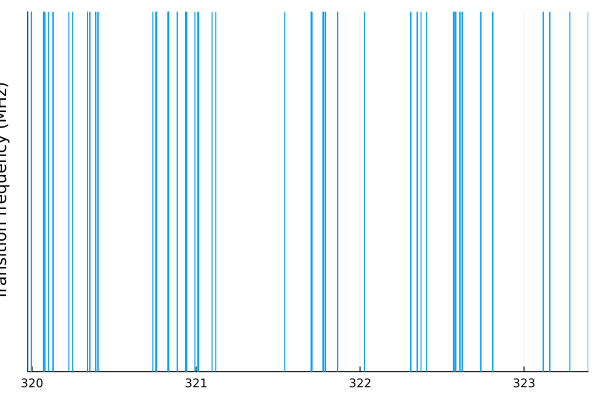

In [150]:
# |N=1, J=3/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
transitions = compute_transitions(N1_J12_states, N2_J32_states, -1, threshold=1e-7)
transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, 0, threshold=1e-7)]
transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-7)]
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :J, :M, :State_1, :N_1, :F_1, :J_1, :M_1, :f, :tdm])
df.f .= df.f .- 39700e6
df.f .*= 1e-6
filter!(row -> row.J == 3/2, df)
filter!(row -> row.J_1 == 3/2, df)
filter!(row -> row.f > 0, df)
filter!(row -> 315 < row.f < 330, df)

# pretty_table(df; nosubheader=true)

display(df)
using Plots
vline(df.f, legend=nothing)
plot!(
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

Row,State,N,F,J,M,State_1,N_1,F_1,J_1,M_1,f,tdm
,Integer,Rational…,Rational…,Rational…,Rational…,Integer,Rational…,Rational…,Rational…,Rational…,Float64,Float64
1,4,1//1,0//1,1//2,0//1,26,2//1,2//1,3//2,2//1,216.868,0.0202451
2,4,1//1,0//1,1//2,0//1,27,2//1,2//1,3//2,1//1,216.932,0.0349743
3,4,1//1,0//1,1//2,0//1,27,2//1,2//1,3//2,1//1,216.932,-0.0349743
4,4,1//1,0//1,1//2,0//1,28,2//1,2//1,3//2,-1//1,217.026,-0.0222046
5,4,1//1,0//1,1//2,0//1,28,2//1,2//1,3//2,-1//1,217.026,-0.0222046
6,4,1//1,0//1,1//2,0//1,30,2//1,1//1,3//2,1//1,217.661,-0.286055
7,4,1//1,0//1,1//2,0//1,30,2//1,1//1,3//2,1//1,217.661,-0.286055
8,4,1//1,0//1,1//2,0//1,31,2//1,1//1,3//2,-1//1,217.754,-0.28496
9,4,1//1,0//1,1//2,0//1,31,2//1,1//1,3//2,-1//1,217.754,0.28496


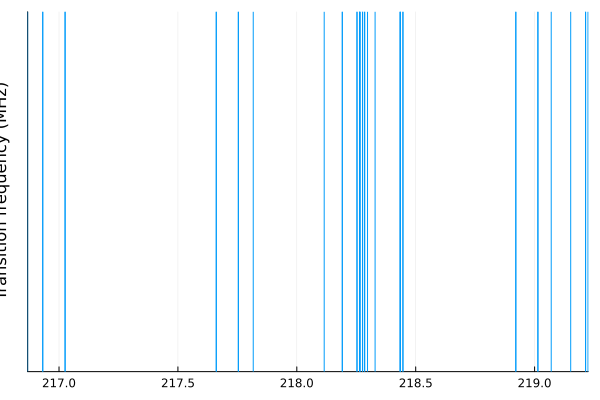

In [151]:
# |N=1, J=1/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
transitions = compute_transitions(N1_J12_states, N2_J32_states, -1, threshold=1e-7)
transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, 0, threshold=1e-7)]
transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-7)]
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :J, :M, :State_1, :N_1, :F_1, :J_1, :M_1, :f, :tdm])
df.f .= df.f .- 39700e6
df.f .*= 1e-6
filter!(row -> row.J == 1/2, df)
filter!(row -> row.J_1 == 3/2, df)
# filter!(row -> row.M == 0, df)
# filter!(row -> row.M_1 == 0, df)
filter!(row -> 215 < row.f < 220, df)

# pretty_table(df; nosubheader=true)

display(df)
using Plots
vline(df.f, legend=nothing)
plot!(
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

### Stark plots

In [148]:
function H_func!(H, scan_values)
    H.parameters.E = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Es = (0:0.5:150.0)
scan_params = (
    E = Es,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03Progress:   1%|█                                        |  ETA: 0:04:13Progress:   1%|█                                        |  ETA: 0:03:11Progress:   2%|█                                        |  ETA: 0:02:32Progress:   2%|█                                        |  ETA: 0:02:06Progress:   2%|█                                        |  ETA: 0:01:48Progress:   3%|██                                       |  ETA: 0:01:34Progress:   3%|██                                       |  ETA: 0:01:24Progress:   3%|██                                       |  ETA: 0:01:15Progress:   4%|██                                       |  ETA: 0:01:08


  4.900400 seconds (4.07 M allocations: 443.400 MiB, 7.51% gc time, 88.18% compilation time)


In [477]:
(matrix_values[1,13:16] .- matrix_values[1,1]) .* 1e-6

4-element Vector{Float64}:
 43.084229859375
 43.056192820312496
 43.084229859375
 44.449186980468745

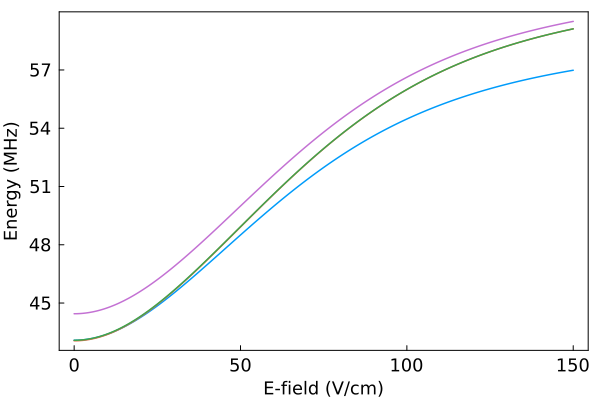

In [478]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,1]
plot(Es, Es_rel[:,13:16] .* 1e-6, linewidth=1.5)
plot!(
    legend=nothing,
    xlabel="E-field (V/cm)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

### Zeeman plots

In [464]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Bs = (0:0.01:2)
scan_params = (
    B = Bs,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.325979 seconds (349.87 k allocations: 1.154 GiB, 10.54% gc time, 21.39% compilation time)


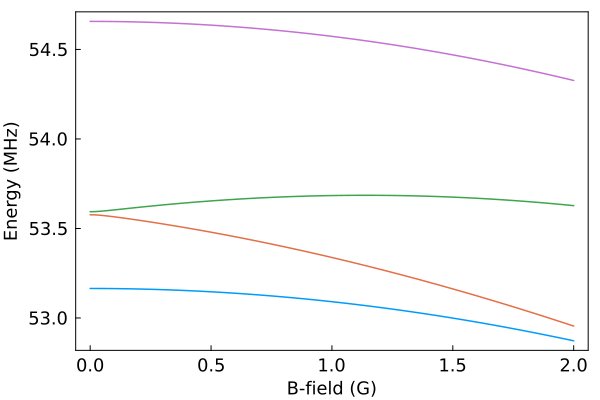

In [465]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,1]
plot(Bs, Es_rel[:,13:16] .* 1e-6, linewidth=1.5)
plot!(
    legend=nothing,
    xlabel="B-field (G)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

In [466]:
H.states[47]

State{HundsCaseB_LinearMolecule}(1.0642669674864479e13, HundsCaseB_LinearMolecule[HundsCaseB_LinearMolecule(0.0, "X", 0, 1, 0, 1/2, 1/2, 0, -1, -1, 1, 1/2, 0, 0, (K = -1, N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 1, 0, 1/2, 1/2, 0, -1, -1, 1, 1/2, 1, -1, (K = -1, N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 1, 0, 1/2, 1/2, 0, -1, -1, 1, 1/2, 1, 0, (K = -1, N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 1, 0, 1/2, 1/2, 0, -1, -1, 1, 1/2, 1, 1, (K = -1, N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 1, 0, 1/2, 1/2, 0, -1, -1, 1, 3/2, 1, -1, (K = -1, N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 1, 0, 1/2, 1/2, 0, -1, -1, 1, 3/2, 1, 0, (K = -1, N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), Hunds

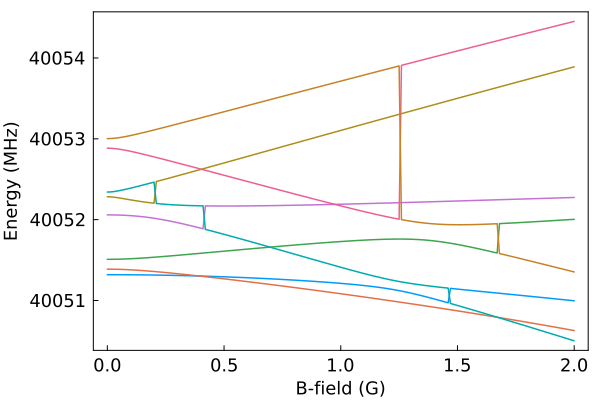

In [473]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,1]
plot(Bs, Es_rel[:,45:52] .* 1e-6, linewidth=1.5)
plot!(
    legend=nothing,
    xlabel="B-field (G)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

### Transition dipole moments for X(010) - A(010)

In [1199]:
H_X010 = load_from_file("CaOH_X010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
H_A000 = load_from_file("CaOH_A000", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
X010_states_caseA = convert_basis(H_X010.states, H_A000.basis)

H_A010 = load_from_file("CaOH_A010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
;

In [1200]:
A_N1_J12_states = H_A010.states[145:148];

In [1213]:
energy(H_A010.states[1]) * 1e-6

489.0045699064211

In [1215]:
energy(H_A010.states[5]) * 1e-6

489.0045719019248

##### To N=1, J=1/2 states

In [1164]:
N1_J12_states = X010_states_caseA[1:4]
sum(TDM(X_state, A_state, p) for X_state in N1_J12_states, A_state in A_N1_J12_states, p in -1:1)

0.7050503196786648 + 0.0im

##### To N=1, J=3/2 states

In [1165]:
N1_J32_states = X010_states_caseA[5:12]
sum(TDM(X_state, A_state, p) for X_state in N1_J32_states, A_state in A_N1_J12_states, p in -1:1)

-0.2692401294283998 + 0.0im

##### To N=2 states

In [1166]:
N2_states = X010_states_caseA[25:64]
sum(TDM(X_state, A_state, p) for X_state in N2_states, A_state in A_N1_J12_states, p in -1:1)

-0.28759887357941666 + 0.0im